This is for exploration of data and some basic modeling.

Scrape data:
* Scrape data at 3 levels
* Create a set of fighters so that pages are not scraped multiple times

First model:
* Logistic regression with simple features
* Create a highly explainable model
* Add more exotic features
    * Moving win streak
    * Approx. peak (age + win streak over time + peak)
* Would not use fight odds

Second model:
* Create the most predictive model
* Could use pre-fight betting odds

In [2]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
import random

In [3]:
base_url = "http://www.ufcstats.com/statistics/events/completed?page=all"
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(base_url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

event_links = []
for a in soup.select('td.b-statistics__table-col a'):
    event_links.append(a['href'])

In [31]:
def parse_event_page(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Event name
    event_name = soup.find('h2').text

    # Extracting the table with all the fights
    table = soup.find('table', {'class': 'b-fight-details__table'})

    fight_data = []

    # Parsing each row in the table
    for index, row in enumerate(table.find_all('tr')[1:]):  # skipping the header row
        cols = row.find_all('td')

        # Split names using the HTML 'p' tag
        names = cols[1].find_all('p')
        a_fighter = names[0].get_text(strip=True) if len(names) > 1 else ""
        b_fighter = names[1].get_text(strip=True) if len(names) > 1 else ""

        # Similarly for other data columns, we need to correctly identify the HTML tags
        # and extract data from them
        a_KD = cols[2].find_all('p')[0].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""
        b_KD = cols[2].find_all('p')[1].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""
        a_STR = cols[3].find_all('p')[0].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""
        b_STR = cols[3].find_all('p')[1].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""
        a_TD = cols[4].find_all('p')[0].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""
        b_TD = cols[4].find_all('p')[1].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""
        a_SUB = cols[5].find_all('p')[0].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""
        b_SUB = cols[5].find_all('p')[1].get_text(strip=True) if len(cols[2].find_all('p')) > 1 else ""

        # fighter links
        links = cols[1].find_all('a')
        a_fighter_link = links[0]['href'] if links else None
        b_fighter_link = links[1]['href'] if len(links) > 1 else None

        details = {
            'fight_number': event_name,
            # change to fighter A and fighter B
            # 'winner': cols[0].get_text(strip=True), # Does not make sense for this data collection
            'a_fighter': a_fighter,
            'b_fighter': b_fighter,
            'a_KD': a_KD,
            'b_KD': b_KD,
            'a_STR': a_STR,
            'b_STR':b_STR,
            'a_TD': a_TD,
            'b_TD':b_TD,
            'a_SUB': a_SUB,
            'b_SUB':b_SUB,
            'a_fighter_link': a_fighter_link,
            'b_fighter_link': b_fighter_link
        }

        fight_data.append(details)

    return fight_data

In [32]:
all_fights = []

for link in event_links[1:25]:
    all_fights.extend(parse_event_page(link))
    print('parsed: '+ link)
    time.sleep(random.uniform(1, 7))

df = pd.DataFrame(all_fights)

parsed: http://www.ufcstats.com/event-details/7abe471b61725980
parsed: http://www.ufcstats.com/event-details/6f812143641ceff8
parsed: http://www.ufcstats.com/event-details/901cddcbfa079097
parsed: http://www.ufcstats.com/event-details/3c6976f8182d9527
parsed: http://www.ufcstats.com/event-details/51b1e2fd9872005b
parsed: http://www.ufcstats.com/event-details/6fb1ba67bef41b37
parsed: http://www.ufcstats.com/event-details/15b1b21cd743d652
parsed: http://www.ufcstats.com/event-details/3dc3022232b79c7a
parsed: http://www.ufcstats.com/event-details/aec273fcb765330d
parsed: http://www.ufcstats.com/event-details/e4bb7e483c4ad318
parsed: http://www.ufcstats.com/event-details/35080a7f406f9ab3
parsed: http://www.ufcstats.com/event-details/1ccff7f0cfdf85eb
parsed: http://www.ufcstats.com/event-details/806975e1b4f47b27
parsed: http://www.ufcstats.com/event-details/f21a3d68fb9df387
parsed: http://www.ufcstats.com/event-details/01dd4cdc2446f665
parsed: http://www.ufcstats.com/event-details/d26394fc0

In [33]:
df = df.drop(['fight_number', 'a_fighter_link', 'b_fighter_link'], axis=1)

# Add a column to represent the winner, with the winner as 1 and the loser as 0
df['winner'] = 1

# Copy the dataframe and flip the a/b columns
df_flipped = df.copy()
df_flipped.columns = df.columns.str.replace('a_', 'temp_').str.replace('b_', 'a_').str.replace('temp_', 'b_')
df_flipped['winner'] = 0

# Concatenate the original and flipped dataframes
df = pd.concat([df, df_flipped])

# Randomly shuffle the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,a_fighter,b_fighter,a_KD,b_KD,a_STR,b_STR,a_TD,b_TD,a_SUB,b_SUB,winner
0,Jake Matthews,Matthew Semelsberger,0,3,32,45,1,3,1,0,0
1,Neil Magny,Daniel Rodriguez,0,0,57,66,5,0,1,0,1
2,Jimmy Flick,Charles Johnson,0,0,7,34,1,0,0,0,0
3,Gilbert Burns,Belal Muhammad,0,0,81,132,0,0,0,0,0
4,Roman Kopylov,Punahele Soriano,0,0,82,39,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
583,Edson Barboza,Billy Quarantillo,1,0,21,19,0,0,0,0,1
584,Leon Edwards,Kamaru Usman,0,0,120,87,0,4,0,0,1
585,Zhang Weili,Carla Esparza,0,0,37,6,0,1,1,0,1
586,Viviane Araujo,Amanda Ribas,0,0,46,98,0,2,2,0,0


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define our features and target
X = df.drop(columns=['a_fighter', 'b_fighter', 'winner'])
y = df['winner']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.864406779661017
Precision:  0.875
Recall:  0.875
F1 Score:  0.875


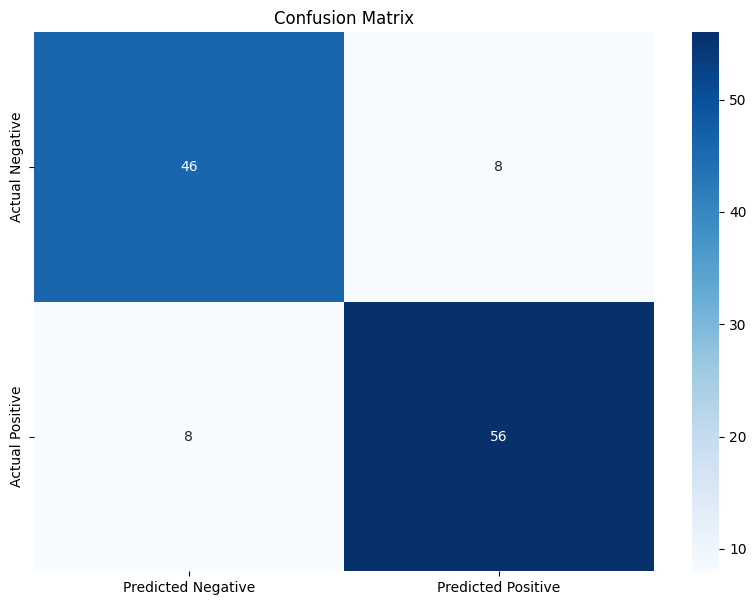

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Convert confusion matrix to a dataframe for better visualization
cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'],
                     index=['Actual Negative', 'Actual Positive'])

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [41]:
coefficients = model.coef_[0]

# Exponentiate the coefficients
odds_ratios = np.exp(coefficients)

# Now print them out along with feature names
for feature, coef, odds_ratio in zip(X.columns, coefficients, odds_ratios):
    print(f'{feature}: coefficient = {coef:.3f}, odds ratio = {odds_ratio:.3f}')

a_KD: coefficient = 1.239, odds ratio = 3.452
b_KD: coefficient = -1.328, odds ratio = 0.265
a_STR: coefficient = 0.085, odds ratio = 1.089
b_STR: coefficient = -0.084, odds ratio = 0.919
a_TD: coefficient = 0.345, odds ratio = 1.411
b_TD: coefficient = -0.396, odds ratio = 0.673
a_SUB: coefficient = 0.989, odds ratio = 2.688
b_SUB: coefficient = -0.895, odds ratio = 0.409


In [43]:
#@title
def parse_fighter_page(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # extract the fighter's record
    record = soup.find('span', {'class': 'b-content__title-record'}).get_text(strip=True)

    data_dict = {}

    # Loop over all list items with the class
    for item in soup.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block'):
        # Get the text and split it into two parts: label and value
        parts = item.get_text(strip=True).split(":")
        if len(parts) > 1:
            label = parts[0].strip()
            value = parts[1].strip()
            # Add to dictionary
            data_dict[label] = value


    fighter_data = {
        'record': record,
        'height': data_dict['Height'],
        'weight': data_dict['Weight'],
        'reach': data_dict['Reach'],
        'stance': data_dict['STANCE'],
        'DOB': data_dict['DOB']
        # Can add takedown avg, etc.
    }
    return fighter_data

# fighter_info = parse_fighter_page('http://www.ufcstats.com/fighter-details/6d35bf94f7d30241')
# print(fighter_info)